In [1]:
!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 813.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 630.2 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=7a3bbc6f9bab1ea0d3f43a72f064b2283c4fa8bc51481a0aa627a1b54636c8e5
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [1]:
import json
import numpy as np 
import pandas as pd 
import csv
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [2]:
def plotClassDistri(df, cols):
    
    labels_val = dict(df[cols].value_counts())
    sorted_vals = [labels_val[key] for key in sorted(labels_val.keys())]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.bar( sorted(labels_val.keys()), sorted_vals)
    plt.title("Distribution of Politeness Intensity", fontsize=20)
    plt.xlabel("Levels of Politness Intensity",fontsize=16)
    plt.ylabel("No. Of Reviews", fontsize=16)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14, rotation=0)
    plt.show()

In [3]:
## Load Data
# df = pd.read_csv('/kaggle/input/iitpolitenesslevels/PolitenessTone_sample.csv')
df = pd.read_csv('/kaggle/input/iitpolitenesslevels/PolitenessTone-COMBINED.csv')
df.drop(['N/C', 'Review ID', 'Venue', 'Annotated By', 'Date','Journal name', 'ESI', 'Article title', 'Review URL'], axis=1, inplace=True)
df.dropna(inplace=True)
df

,review,Tone
0,Please refer to the paper Discovering structur...,5.0
1,One issue of the use of cross task transfer pe...,3.0
2,Learning incoherent sparse and low rank patter...,3.0
3,"However , a disadvantage of the proposed metho...",3.0
4,- Comparison with existing clustered MTL metho...,3.0
...,...,...
2495,Changes made by the authors are acceptable.,4.0
2496,In my opinion the new version of the paper is ...,3.0
2497,This paper presents Power Quality Disturbance ...,3.0
2498,"The paper presentation is good. \n However, Cr...",4.0


In [4]:
df.isna().sum()

review    0
Tone      0
dtype: int64

In [5]:
X = df.review.values
y = df.Tone.values

X.shape, y.shape

((2497,), (2497,))

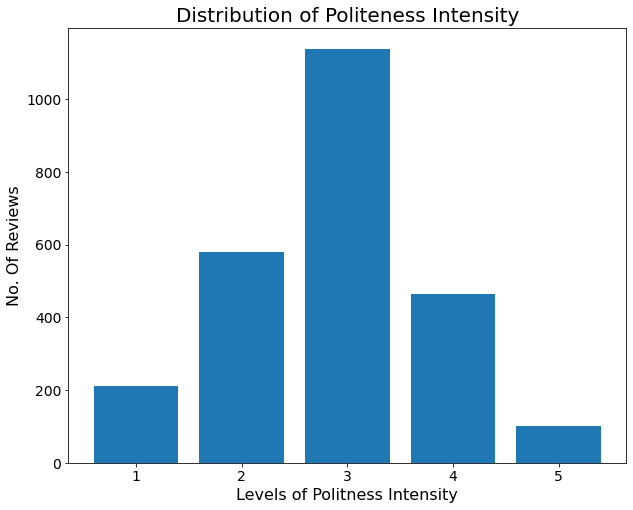

In [6]:
plotClassDistri(df,'Tone')

In [7]:
df.Tone.value_counts()

3.0    1139
2.0     581
4.0     465
1.0     210
5.0     102
Name: Tone, dtype: int64

In [16]:
def calcAvgSentLen():
    reviews = df.review.values
    len_arr = []
    for r in reviews: 
        len_arr.append(len(r.split()) )
    
    print('\nAVG NO. OF WORDS : ',sum(len_arr)//len(len_arr))

calcAvgSentLen()


AVG NO. OF WORDS :  21


# Handle Imbalance 

### UPSAMPLING LESS FREQ. LEVELS

In [10]:
MAX_RECORDS_PER_CLASSS = df.Tone.value_counts().max()
UNIQUE_CATEGORIES = df.Tone.unique()

upsampled_df = pd.DataFrame(columns= df.columns)
for label in UNIQUE_CATEGORIES:
    df_class = df[df.Tone == label]
    # print(label , ": ", df_class.shape)
    df_class = df_class.sample(MAX_RECORDS_PER_CLASSS , replace=True)
    print(label , " : ", df_class.shape)
    upsampled_df = pd.concat([upsampled_df, df_class], axis=0)

upsampled_df.reset_index(inplace=True)
upsampled_df.drop('index', axis=1, inplace=True)
print("\nFINAL UPSAMPLED DATAFRAME : " , upsampled_df.shape)

5.0  :  (1139, 2)
3.0  :  (1139, 2)
4.0  :  (1139, 2)
2.0  :  (1139, 2)
1.0  :  (1139, 2)

FINAL UPSAMPLED DATAFRAME :  (5695, 2)


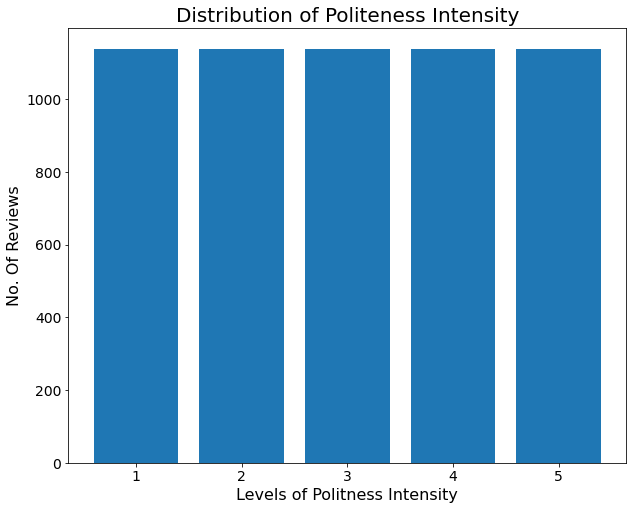

In [11]:
plotClassDistri(upsampled_df, 'Tone')

In [ ]:
upsampled_df.to_csv('upsampled_data.csv', index=False)

# OHE

In [101]:
df = pd.read_csv('./upsampled_data.csv')
df.drop('N/C',axis=1, inplace=True)
df.dropna(inplace=True)

In [102]:
df.head()

,review,Tone
0,Please see the attachment.,5.0
1,Dear authors. \n \n Thank you for addressing ...,5.0
2,I'd like to thank the auhthors for their revis...,5.0
3,Could you please show the train/test accuracie...,5.0
4,Thanks for your rivision response.paper accepted,5.0


In [103]:
# LABEL ENCODER

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

ohe = OneHotEncoder(drop=None, dtype= np.int32,  handle_unknown='error')
transformer = make_column_transformer(
    ( ohe, ['Tone']),
    remainder='passthrough')

transformed = transformer.fit_transform(df)
transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [104]:
transformed_df.head(3)

,onehotencoder__x0_1.0,onehotencoder__x0_2.0,onehotencoder__x0_3.0,onehotencoder__x0_4.0,onehotencoder__x0_5.0,review
0,0,0,0,0,1,Please see the attachment.
1,0,0,0,0,1,Dear authors. \n \n Thank you for addressing ...
2,0,0,0,0,1,I'd like to thank the auhthors for their revis...


In [106]:
cols = ['HIMP', 'IMP', 'N', 'P', 'HP', 'review']
ordered_cols = ['review','HIMP', 'IMP', 'N', 'P', 'HP']
processed_df = pd.DataFrame(transformed, columns=cols)
processed_df = processed_df[ordered_cols]
processed_df['Tone'] =  df.Tone 


# SHUFFLE
processed_df = processed_df.sample(frac=1).reset_index(drop=True)
processed_df.head()

,review,HIMP,IMP,N,P,HP,Tone
0,"This paper is definitely not suitable to PNAS,...",0,0,0,1,0,4.0
1,"Reading this paper, I am struck by the eleganc...",0,0,0,0,1,5.0
2,It would also be interesting to know the numbe...,0,0,1,0,0,3.0
3,My two cents : this work has both theoretical ...,0,0,1,0,0,3.0
4,Thank you for your contribution.,0,0,0,0,1,5.0


In [107]:
processed_df.to_csv('upsampled_ohe_politnessLevel.csv', index=False)

# TRAIN TEST SPLIT

In [108]:
df = pd.read_csv('./upsampled_ohe_politnessLevel.csv')
df.head()

,review,HIMP,IMP,N,P,HP,Tone
0,"This paper is definitely not suitable to PNAS,...",0,0,0,1,0,4.0
1,"Reading this paper, I am struck by the eleganc...",0,0,0,0,1,5.0
2,It would also be interesting to know the numbe...,0,0,1,0,0,3.0
3,My two cents : this work has both theoretical ...,0,0,1,0,0,3.0
4,Thank you for your contribution.,0,0,0,0,1,5.0


In [109]:
# TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split
X = df
y = df.Tone
train, test, _, _ = train_test_split(X, y, test_size = 0.2 , shuffle=True, stratify=y)

In [110]:
train, val, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.85*len(df))])
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.shape , test.shape, val.shape 

((4556, 7), (855, 7), (284, 7))

In [111]:
train.to_csv('train.csv', index = False)
test.to_csv('test.csv', index = False)
val.to_csv('val.csv', index = False)

#  EMBEDS FOR TRAIN AND TEST¶

In [112]:
politness_categories = ['HIMP', 'IMP', 'N', 'P', 'HP'] 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('val.csv')

In [113]:
train.shape , test.shape, val.shape

((4556, 7), (855, 7), (284, 7))

In [122]:
train.head(3)

,review,HIMP,IMP,N,P,HP,Tone
0,I believe this paper to be borderline .,0,1,0,0,0,2.0
1,"There are a few details missing , like the bat...",0,0,1,0,0,3.0
2,Its disappointing .,1,0,0,0,0,1.0


In [123]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [124]:
def loadModel(embed_model_name):
    tokenizer = AutoTokenizer.from_pretrained(embed_model_name) 
    embed_model = AutoModel.from_pretrained(embed_model_name)
    
    return embed_model, tokenizer

def sent2embed(embed_model, tokenizer, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = embed_model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

# PRE-PROCESS 
def BertEmbed(reviews, embed_model, tokenizer):
    
    embed_arr = []
    start = reviews.index[0]
    for idx in range(len(reviews.index)):
        print(start + idx)
        outputs = sent2embed(embed_model, tokenizer, reviews.loc[start+idx])
        embed_arr.append([outputs[1].detach().numpy()[0]])

    embed_train_arr = tf.stack(embed_arr)

    return embed_train_arr

In [125]:
# # TEST WITH 1 SAMPLE
# embed_model,tokenizer = loadModel('gsarti/scibert-nli')
# BertEmbed(val.review, embed_model)

In [126]:
import pickle

def automateEmbedAndSave(embed_model_name, name):
# EMBEDS
    print(f'\n\n***** {name} *****')
    embed_model,tokenizer = loadModel(embed_model_name)
    embeds_train = BertEmbed(train.review, embed_model, tokenizer)
    embeds_test = BertEmbed(test.review, embed_model, tokenizer)
    embeds_val = BertEmbed(val.review, embed_model, tokenizer)
    print(f'TRAIN SHAPE : {embeds_train.shape}\nTEST SHAPE : {embeds_test.shape}\nVAL SHAPE : {embeds_val.shape}')
    
    
# SAVE FILES
    # TRAIN
    save_path = name+'_train.pickle'
    with open(save_path, 'wb') as handle:
        pickle.dump(embeds_train, handle)
        handle.close()
    print('SAVED TRAIN TO PICKLE --> ', name)
    
    # TEST
    save_path = name+'_test.pickle'
    with open(save_path, 'wb') as handle:
        pickle.dump(embeds_test, handle)
        handle.close() 
    print('SAVED TEST TO PICKLE --> ', name)
    
    # VAL
    save_path = name+'_val.pickle'
    with open(save_path, 'wb') as handle:
        pickle.dump(embeds_val, handle)
        handle.close() 
    print('SAVED TEST TO PICKLE --> ', name)
    


In [127]:
# LOAD EMBEDS DATASET

def loadPickle(name):
    
    LOAD_PATH = './'+name+'_train.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        train_embeds = pickle.load(handle)
        handle.close()

    LOAD_PATH = './'+name+'_test.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        test_embeds = pickle.load(handle)
        handle.close()
        
    LOAD_PATH = './'+name+'_val.pickle'
    with open(LOAD_PATH, 'rb') as handle:
        val_embeds = pickle.load(handle)
        handle.close()
        
    y_train = pd.read_csv('y_train.csv')
    y_val = pd.read_csv('y_val.csv')
    y_test = pd.read_csv('y_test.csv')
    
    print('\n***** LOADED '+ name+' *****\n')
    print(f'TRAIN SHAPE : {train_embeds.shape}\nTEST SHAPE : {test_embeds.shape}\nVAL SHAPE : {val_embeds.shape}\nY-TRAIN SHAPE : {y_train.shape}\nY-TEST SHAPE : {y_test.shape}\nY-VAL SHAPE : {y_val.shape}')

    return train_embeds, test_embeds, val_embeds, y_train, y_test, y_val

In [128]:
y_train = train[politness_categories]
y_test = test[politness_categories]
y_val = val[politness_categories]

y_train.to_csv('y_train.csv', index = False)
y_test.to_csv('y_test.csv', index = False)
y_val.to_csv('y_val.csv', index = False)

## A) SCIBERT

In [130]:
embed_model_name = 'gsarti/scibert-nli'
automateEmbedAndSave(embed_model_name, 'SCIBERT')



***** SCIBERT *****
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271


2022-12-04 16:03:17.787789: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [131]:
sci_train_embeds, sci_test_embeds, sci_val_embeds, y_train, y_test, y_val = loadPickle('SCIBERT')


***** LOADED SCIBERT *****

TRAIN SHAPE : (4556, 1, 768)
TEST SHAPE : (855, 1, 768)
VAL SHAPE : (284, 1, 768)
Y-TRAIN SHAPE : (4556, 5)
Y-TEST SHAPE : (855, 5)
Y-VAL SHAPE : (284, 5)


## B) TOXIC-BERT
https://huggingface.co/troesy/toxicBERT_3epoch?text=My+name+is+Clara+and+I+live+in+Berkeley%2C+California.

In [ ]:
embed_model_name = 'troesy/toxicBERT_3epoch'
# embed_model_name ='mohsenfayyaz/bert-base-uncased-toxicity'

automateEmbedAndSave(embed_model_name, 'TOXIC-BERT')



***** TOXIC-BERT *****


Downloading:   0%|          | 0.00/515 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [221]:
toxic_train_embeds, toxic_test_embeds, toxic_val_embeds, y_train, y_test, y_val = loadPickle('TOXIC-BERT')


***** LOADED TOXIC-BERT *****

TRAIN SHAPE : (44, 1, 768)
TEST SHAPE : (9, 1, 768)
VAL SHAPE : (2, 1, 768)
Y-TRAIN SHAPE : (44, 5)
Y-TEST SHAPE : (9, 5)
Y-VAL SHAPE : (2, 5)


## C) HATE-BERT
https://huggingface.co/GroNLP/hateBERT <br>
https://aclanthology.org/2021.woah-1.3/

In [222]:
embed_model_name ='GroNLP/hateBERT'
automateEmbedAndSave(embed_model_name, 'HATE-BERT')



***** HATE-BERT *****


Some weights of the model checkpoint at GroNLP/hateBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
0
1
2
3
4
5
6
7
8
0
1
TRAIN SHAPE : (44, 1, 768)
TEST SHAPE : (9, 1, 768)
VAL SHAPE : (2, 1, 768)
SAVED TRAIN TO PICKLE -->  HATE-BERT
SAVED TEST TO PICKLE -->  HATE-BERT
SAVED TEST TO PICKLE -->  HATE-BERT


In [223]:
hate_train_embeds, hate_test_embeds, hate_val_embeds, y_train, y_test, y_val = loadPickle('HATE-BERT')


***** LOADED HATE-BERT *****

TRAIN SHAPE : (44, 1, 768)
TEST SHAPE : (9, 1, 768)
VAL SHAPE : (2, 1, 768)
Y-TRAIN SHAPE : (44, 5)
Y-TEST SHAPE : (9, 5)
Y-VAL SHAPE : (2, 5)


_____________________________

# TOKENIZATION & WORD2VEC

In [12]:
EMBEDDING_DIMENSION = 300
MAXLEN = 768

In [13]:
from wordcloud import WordCloud
import re

In [14]:
df.head()

,review,Tone
0,Please refer to the paper Discovering structur...,5.0
1,One issue of the use of cross task transfer pe...,3.0
2,Learning incoherent sparse and low rank patter...,3.0
3,"However , a disadvantage of the proposed metho...",3.0
4,- Comparison with existing clustered MTL metho...,3.0


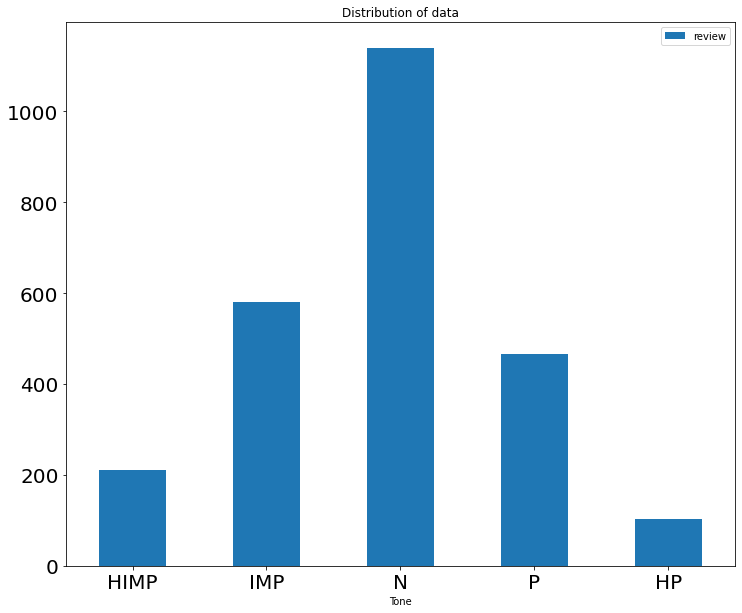

In [15]:
politeness = ['HIMP', 'IMP', 'N', 'P', 'HP']
ax = df.groupby('Tone').count().plot(kind='bar', title='Distribution of data',legend=True, figsize=(12,10), fontsize=20)
ax = ax.set_xticklabels(politeness, rotation=0, fontsize=20)

In [16]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('/kaggle/input/contractions/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"


def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
        # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet


In [17]:
%%time
df['processed_text'] = df.review.apply(preprocess_apply)

CPU times: user 190 ms, sys: 545 µs, total: 191 ms
Wall time: 190 ms


# VISUALISE DATA

In [24]:
train = pd.read_csv('/kaggle/input/iitpolitenesslevels/train.csv')
val = pd.read_csv('/kaggle/input/iitpolitenesslevels/val.csv')
test = pd.read_csv('/kaggle/input/iitpolitenesslevels/test.csv')

In [25]:
train.shape,test.shape, val.shape, 

((4556, 7), (855, 7), (284, 7))

In [26]:
df['processed_text'].shape

(2497,)

In [27]:
from gensim.models import Word2Vec

Word2vec_data = list(map(lambda x: x.split(), df['processed_text'].values))

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_data,
                 vector_size= EMBEDDING_DIMENSION,
                 workers=8
#                  min_count=5
                )

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 1353


## TOKENIZATION & PADDING

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(df['processed_text'].values)
VOCAB_LEN = len(word2vec_model.wv.key_to_index) + 500
tokenizer.num_words = VOCAB_LEN
print("Tokenizer vocab length:", tokenizer.num_words) 

Tokenizer vocab length: 1853


In [30]:
# PADDING SEQUENCE
X_train = pad_sequences(tokenizer.texts_to_sequences(train.review.values), maxlen=MAXLEN)
X_test  = pad_sequences(tokenizer.texts_to_sequences(test.review.values) , maxlen=MAXLEN)
X_val  = pad_sequences(tokenizer.texts_to_sequences(val.review.values) , maxlen=MAXLEN)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)
print("X_val.shape :", X_val.shape)

X_train.shape: (4556, 768)
X_test.shape : (855, 768)
X_val.shape : (284, 768)


In [31]:
# STORED TOKENIZED AND PROCESSED DATA

pd.DataFrame(X_train).to_csv('Tokennized_Processed_X_train-BiLSTM.csv',index = False)
pd.DataFrame(X_test).to_csv('Tokennized_Processed_X_test-BiLSTM.csv', index = False)
pd.DataFrame(X_val).to_csv('Tokennized_Processed_X_val-BiLSTM.csv', index = False)

## EMBEDDING MATRIX

In [32]:
embedding_matrix = np.zeros((VOCAB_LEN, EMBEDDING_DIMENSION))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (1853, 300)


In [33]:
with open('./Embedding-Matrix.pickle', 'wb') as handle:
        pickle.dump(embedding_matrix, handle)
        handle.close()